In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage import io, color, exposure, feature, filters


In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
def load_images(pothole_dir, plain_road_dir, img_size=(128, 128)):
    """
    Load images from directories and create labeled dataset
    """
    images = []
    labels = []

    # Load pothole images (class 1)
    for filename in os.listdir(pothole_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(pothole_dir, filename)
            try:
                img = io.imread(img_path)
                # Handle RGBA images by removing the alpha channel
                if img.shape[-1] == 4:
                    img = img[..., :3]
                images.append(img)
                labels.append(1)  # 1 for pothole
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    # Load plain road images (class 0)
    for filename in os.listdir(plain_road_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(plain_road_dir, filename)
            try:
                img = io.imread(img_path)
                # Handle RGBA images by removing the alpha channel
                if img.shape[-1] == 4:
                    img = img[..., :3]
                images.append(img)
                labels.append(0)  # 0 for plain road
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return images, labels

In [7]:
def basic_preprocessing(images, img_size=(128, 128)):
    """
    Basic preprocessing: resize and normalize
    """
    processed_images = []

    for img in images:
        # Handle grayscale images
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=2)

        # Handle images with alpha channel
        if img.shape[2] == 4:
            img = img[:,:,:3]

        # Resize image
        img = tf.image.resize(img, img_size).numpy()

        # Normalize pixel values to [0,1]
        img = img / 255.0

        processed_images.append(img)

    return np.array(processed_images)

In [20]:
def grayscale_preprocessing(images, img_size=(128, 128)):
    """
    Convert to grayscale, then resize and normalize
    """
    processed_images = []

    for img in images:
        # Handle images with alpha channel or more than 3 channels
        if len(img.shape) == 3 and img.shape[2] > 3: # Changed condition to handle more than 3 channels
            img = img[:,:,:3]  # Keep only the first 3 channels (RGB)

        # Convert to grayscale if not already
        if len(img.shape) == 3 and img.shape[2] == 3:
            img = color.rgb2gray(img)

        # Resize image
        img = tf.image.resize(img[..., np.newaxis], img_size).numpy()

        # Normalize pixel values to [0,1]
        img = img / 255.0

        processed_images.append(img)

    return np.array(processed_images)

In [9]:
def contrast_enhancement_preprocessing(images, img_size=(128, 128)):
    """
    Apply contrast enhancement, then resize and normalize
    """
    processed_images = []

    for img in images:
        # Handle grayscale images
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=2)

        # Handle images with alpha channel
        if img.shape[2] == 4:
            img = img[:,:,:3]

        # Apply contrast enhancement
        img = exposure.equalize_hist(img)

        # Resize image
        img = tf.image.resize(img, img_size).numpy()

        processed_images.append(img)

    return np.array(processed_images)

In [24]:
def combined_preprocessing(images, img_size=(128, 128)):
    """
    Combined approach: grayscale + contrast enhancement + edge features
    """
    processed_images = []

    for img in images:
        # Handle images with alpha channel
        if len(img.shape) == 3 and img.shape[2] == 4:
            img = img[:,:,:3]  # Keep only the first 3 channels (RGB)

        # Convert to grayscale if not already
        if len(img.shape) == 3 and img.shape[2] == 3:
            gray = color.rgb2gray(img)
        else:
            gray = img

        # Apply contrast enhancement
        enhanced = exposure.equalize_hist(gray)

        # Calculate edges
        edges = feature.canny(enhanced, sigma=1.5)

        # Enhance textures with sobel filter
        sobel_h = filters.sobel_h(enhanced)
        sobel_v = filters.sobel_v(enhanced)
        sobel_mag = np.sqrt(sobel_h**2 + sobel_v**2)

        # Stack features into 3-channel image
        feature_img = np.stack([enhanced, edges, sobel_mag], axis=2)

        # Resize image
        feature_img = tf.image.resize(feature_img, img_size).numpy()

        processed_images.append(feature_img)

    return np.array(processed_images)

In [22]:
def edge_detection_preprocessing(images, img_size=(128, 128)):
    """
    Apply edge detection, then resize and normalize
    """
    processed_images = []

    for img in images:
        # Handle images with alpha channel
        if len(img.shape) == 3 and img.shape[2] == 4:
            img = img[:,:,:3]

        # Convert to grayscale if not already
        if len(img.shape) == 3 and img.shape[2] == 3:
            gray = color.rgb2gray(img)
        else:
            gray = img

        # Apply Canny edge detection
        edges = feature.canny(gray, sigma=1)

        # Convert edges to float32 before resizing
        edges = edges.astype(np.float32)  # This line is added

        # Resize image
        edges = tf.image.resize(edges[..., np.newaxis], img_size).numpy()

        processed_images.append(edges)

    return np.array(processed_images)

In [11]:
def contrast_enhancement_preprocessing(images, img_size=(128, 128)):
    """
    Apply contrast enhancement, then resize and normalize
    """
    processed_images = []

    for img in images:
        # Handle grayscale images
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=2)

        # Handle images with alpha channel
        if img.shape[2] == 4:
            img = img[:,:,:3]

        # Apply contrast enhancement
        img = exposure.equalize_hist(img)

        # Resize image
        img = tf.image.resize(img, img_size).numpy()

        processed_images.append(img)

    return np.array(processed_images)




In [14]:
def create_simple_cnn(input_shape):
    """
    Create a simple CNN model for pothole detection
    """
    model = models.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Flatten and fully connected layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [18]:
def train_and_evaluate(X_train, y_train, X_val, y_val, input_shape, epochs=15, batch_size=32):
    """
    Train and evaluate the model
    """
    # Create model
    model = create_simple_cnn(input_shape)

    # Data augmentation for training
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2
    )
    datagen.fit(X_train)

    # Train the model
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train) // batch_size
    )

    # Evaluate the model
    val_loss, val_acc = model.evaluate(X_val, y_val)
    print(f"Validation accuracy: {val_acc:.4f}")

    return model, history

In [15]:
def compare_preprocessing_techniques(images, labels, img_size=(128, 128)):
    """
    Compare different preprocessing techniques
    """
    # Split data into training and validation sets
    indices = np.arange(len(images))
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)

    # Define preprocessing techniques
    techniques = {
        'Basic': basic_preprocessing,
        'Grayscale': grayscale_preprocessing,
        'Edge Detection': edge_detection_preprocessing,
        'Contrast Enhanced': contrast_enhancement_preprocessing,
        'Combined Features': combined_preprocessing
    }

    results = {}

    for name, preprocess_func in techniques.items():
        print(f"\n--- Testing {name} preprocessing ---")

        # Apply preprocessing
        processed_images = preprocess_func(images, img_size)

        # Get input shape based on the preprocessing result
        if len(processed_images.shape) == 4:
            input_shape = processed_images.shape[1:]
        else:
            # Add channel dimension if missing
            processed_images = processed_images[..., np.newaxis]
            input_shape = processed_images.shape[1:]

        # Create training and validation sets
        X_train = processed_images[train_idx]
        y_train = np.array(labels)[train_idx]
        X_val = processed_images[val_idx]
        y_val = np.array(labels)[val_idx]

        # Train and evaluate model
        model, history = train_and_evaluate(X_train, y_train, X_val, y_val, input_shape, epochs=10)

        # Store results
        results[name] = {
            'val_accuracy': history.history['val_accuracy'][-1],
            'history': history
        }

    # Print comparison
    print("\n--- Preprocessing Technique Comparison ---")
    for name, result in results.items():
        print(f"{name}: Validation Accuracy = {result['val_accuracy']:.4f}")

    return results


In [16]:
def plot_comparison_results(results):
    """
    Plot accuracy comparison of different preprocessing techniques
    """
    plt.figure(figsize=(12, 6))

    for name, result in results.items():
        plt.plot(result['history'].history['val_accuracy'], label=f"{name}")

    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Loading images...
Loaded 203 images (103 potholes, 100 plain roads)

--- Testing Basic preprocessing ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7064 - loss: 0.6955 - val_accuracy: 0.4878 - val_loss: 1.4272
Epoch 2/10
1/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8750 - loss: 0.6459

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8750 - loss: 0.6459 - val_accuracy: 0.4878 - val_loss: 0.9965
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9570 - loss: 0.1319 - val_accuracy: 0.6585 - val_loss: 0.6508
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.9062 - loss: 0.2749 - val_accuracy: 0.6585 - val_loss: 0.6269
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9339 - loss: 0.1359 - val_accuracy: 0.7317 - val_loss: 0.6453
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.9688 - loss: 0.2152 - val_accuracy: 0.6341 - val_loss: 0.6723
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9366 - loss: 0.1915 - val_accuracy: 0.5366 - val_loss: 1.0331
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9375 - loss: 0.1096 - val_accuracy: 0.5366 - val_loss: 1.1144
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9621 - loss: 0.1179 - val_accuracy: 0.5122 - val_loss: 1.8318
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7171 - loss: 0.5270 - val_accuracy: 0.5122 - val_loss: 1.8129
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.9062 - loss: 0.2151 - val_accuracy: 0.5122 - val_loss: 1.4160
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9374 - loss: 0.1944 - val_accuracy: 0.7805 - val_loss: 0.4263
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9688 - loss: 0.0737 - val_accuracy: 0.8537 - val_loss: 0.3938
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9789 - loss: 0.0785 - val_accuracy: 0.9512 - val_loss: 0.3428
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.0000 - loss: 0.0341 - val_accuracy: 0.9512 - val_loss: 0.3348
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.8765 - loss: 0.2006 - val_accuracy: 0.7073 - val_loss: 0.4984
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9688 - loss: 0.0804 - val_accuracy: 0.5122 - val_loss: 0.6127
E

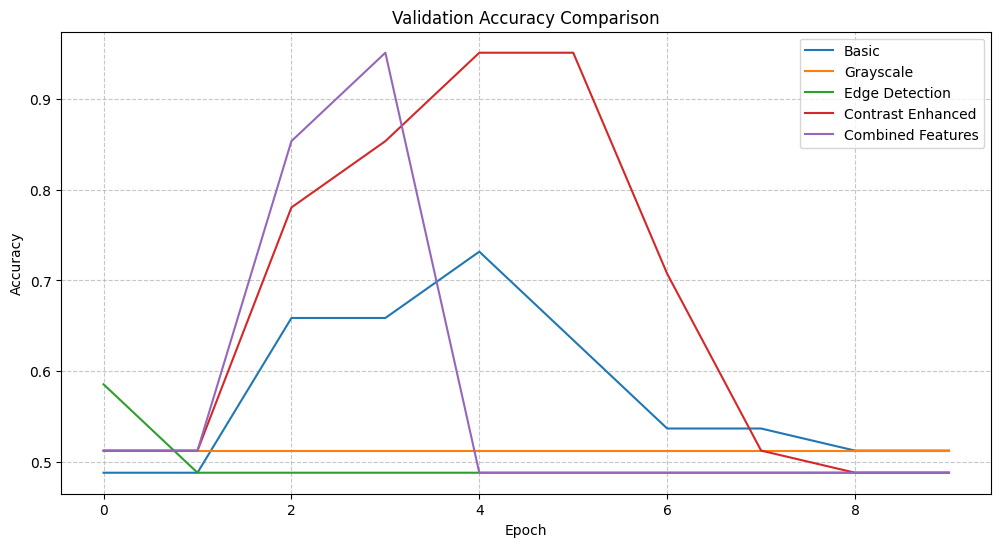


Best preprocessing technique: Basic


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6956 - loss: 0.5784 - val_accuracy: 0.4878 - val_loss: 0.7826
Epoch 2/20
1/5 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9375 - loss: 0.5699

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9375 - loss: 0.5699 - val_accuracy: 0.4878 - val_loss: 0.8635
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.9256 - loss: 0.2775 - val_accuracy: 0.7317 - val_loss: 0.6139
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.9375 - loss: 0.5290 - val_accuracy: 0.5854 - val_loss: 0.6601
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9666 - loss: 0.1037 - val_accuracy: 0.5122 - val_loss: 1.1933
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.9062 - loss: 0.1915 - val_accuracy: 0.5122 - val_loss: 1.1495
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.9657 - loss: 0.1173 - val_accuracy: 0.5366 - val_loss: 0.9625
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.5000 - loss: 0.8113 - val_accuracy: 0.5366 - val_loss: 1.0746
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.9769 - loss: 0.0535 - val_accuracy: 0.5122 - val_loss: 1.2658
Epoch 10/20
5/

Validation accuracy: 0.5122
Final model saved as 'pothole_detection_model.h5'


In [25]:
def main():
    """
    Main execution function
    """
    # Set directories (update these paths to your data location)
    pothole_dir = '/content/drive/MyDrive/dm_new/pothole_sample'
    plain_road_dir = '/content/drive/MyDrive/dm_new/plainroad_sample'
    img_size = (128, 128)

    # Load images
    print("Loading images...")
    images, labels = load_images(pothole_dir, plain_road_dir, img_size)
    print(f"Loaded {len(images)} images ({sum(labels)} potholes, {len(labels) - sum(labels)} plain roads)")

    # Compare preprocessing techniques
    results = compare_preprocessing_techniques(images, labels, img_size)

    # Plot results
    if results:
        plot_comparison_results(results)

        # Use the best technique for final model
        best_technique = max(results, key=lambda k: results[k]['val_accuracy'])
        print(f"\nBest preprocessing technique: {best_technique}")

        # Get the preprocessing function
        techniques = {
            'Basic': basic_preprocessing,
            'Grayscale': grayscale_preprocessing,
            'Edge Detection': edge_detection_preprocessing,
            'Contrast Enhanced': contrast_enhancement_preprocessing,
            'Combined Features': combined_preprocessing
        }

        preprocess_func = techniques[best_technique]
        processed_images = preprocess_func(images, img_size)

        # Get input shape
        if len(processed_images.shape) == 4:
            input_shape = processed_images.shape[1:]
        else:
            processed_images = processed_images[..., np.newaxis]
            input_shape = processed_images.shape[1:]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            processed_images, np.array(labels), test_size=0.2, random_state=42, stratify=labels
        )

        # Train final model
        final_model, _ = train_and_evaluate(X_train, y_train, X_test, y_test, input_shape, epochs=20)

        # Save the model
        final_model.save('pothole_detection_model.h5')
        print("Final model saved as 'pothole_detection_model.h5'")

if __name__ == "__main__":
    main()